# Reproducing the cross resonance calculation in 1804.04073

We will try to reproduce Figure 1-4 of arXiv:1804.04073 (Magesan and Gambetta, "Effective Hamiltonian models of the cross-resonance gate", [PRA 101, 052308](https://doi.org/10.1103/PhysRevA.101.052308)).

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
import logging
import numpy as np
import h5py
import matplotlib.pyplot as plt
from qudit_sim import HamiltonianBuilder, SystemFrame, FrequencyScale
from qudit_sim.apps import find_heff_blkdiag
from qudit_sim.visualization import plot_amplitude_scan

In [2]:
twopi = np.pi * 2.

hgen = HamiltonianBuilder()
hgen.add_qudit(qudit_id='q0', num_levels=3, qubit_frequency=5.114e+9 * twopi, anharmonicity=-0.330e+9 * twopi, drive_amplitude=140.e+6 * twopi)
hgen.add_qudit(qudit_id='q1', num_levels=3, qubit_frequency=4.914e+9 * twopi, anharmonicity=-0.330e+9 * twopi, drive_amplitude=140.e+6 * twopi)
hgen.add_coupling('q0', 'q1', 3.8e+6 * twopi)

# Frame where the IZ component is zero in the qubit space when there is no drive
frame = SystemFrame('noiz2', hgen)

dt = 0.2e-9

In [3]:
eigenvalues = hgen.eigenvalues()
cr_drive_frequency = np.mean(eigenvalues[:2, 1] - eigenvalues[:2, 0])
cr_drive_frequency

30875986652.687447

In [4]:
amplitudes = np.linspace(0., 0.5, 10)
num_points = 128
pulse_shape = (1280 * dt, 1024 * dt, 64 * dt)

In [5]:
components_list = find_heff_blkdiag(hgen,
                                    qudit='q0',
                                    frequency=cr_drive_frequency,
                                    amplitude=amplitudes,
                                    frame=frame,
                                    num_points=num_points,
                                    pulse_shape=pulse_shape,
                                    pulse_sim_solver='jax',
                                    comp_dim=(2, 2))

In [6]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude

## Figure 1

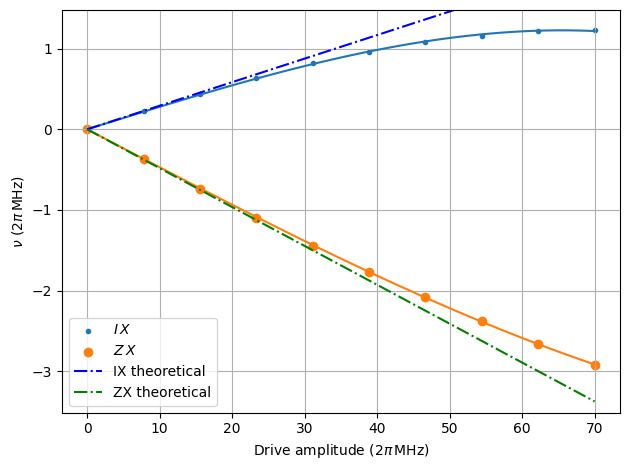

In [7]:
selection = [(0, 1), (3, 1)]
plot = plot_amplitude_scan(physical_amplitudes, components_list,
                           select_components=selection,
                           amp_scale=FrequencyScale.MHz,
                           compo_scale=FrequencyScale.MHz)
ax = plot[0].axes[0]
amp_scale = plot[3]
freq_scale = plot[4]

amps_fine = np.linspace(amplitudes[0], amplitudes[-1], 100)
j = hgen.coupling('q0', 'q1')
omega = hgen.qudit_params('q0').drive_amplitude
delta = hgen.qudit_params('q0').qubit_frequency - hgen.qudit_params('q1').qubit_frequency
alpha = hgen.qudit_params('q0').anharmonicity
ix_linear = -j * omega / (delta + alpha) * amps_fine
zx_linear = -j * omega / delta * (alpha / (alpha + delta)) * amps_fine
ax.plot(amps_fine * omega / amp_scale.pulsatance_value,
        ix_linear / freq_scale.pulsatance_value, '-.b', label='IX theoretical')
ax.plot(amps_fine * omega / amp_scale.pulsatance_value,
        zx_linear / freq_scale.pulsatance_value, '-.g', label='ZX theoretical')
ax.legend();

## Figure 2

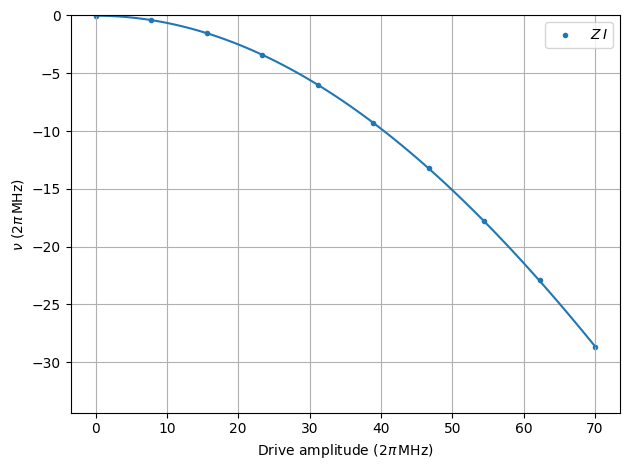

In [8]:
selection = [(3, 0)]
plot_amplitude_scan(physical_amplitudes, components_list,
                    select_components=selection,
                    amp_scale=FrequencyScale.MHz,
                    compo_scale=FrequencyScale.MHz);

## Figure 3

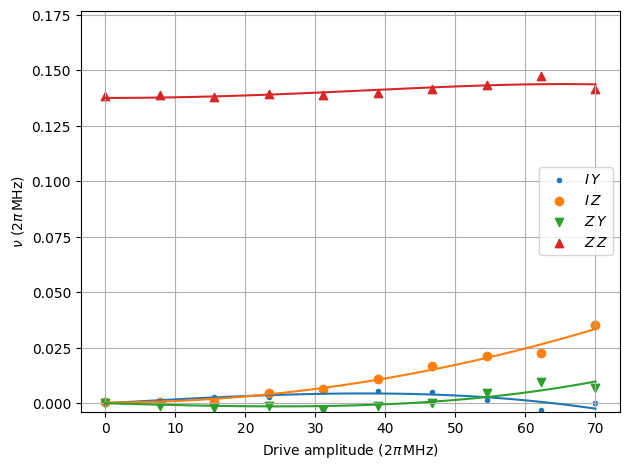

In [9]:
selection = [(0, 2), (0, 3), (3, 2), (3, 3)]
plot_amplitude_scan(physical_amplitudes, components_list,
                    select_components=selection,
                    amp_scale=FrequencyScale.MHz,
                    compo_scale=FrequencyScale.MHz);

There is some numerical precision issue in sesolve which generates spurious diagonal terms in the Hamiltonian in the presence of a pulse, regardless of the amplitude. Small-amplitude components seem to suffer from numerical instabilities in general..

## Figure 6

In [11]:
hgen_ct = hgen.copy()
hgen_ct.add_crosstalk('q0', 'q0', -1.)
hgen_ct.add_crosstalk('q0', 'q1', 0.071 * np.exp(0.62j))

components_list_ct = find_heff_blkdiag(hgen_ct,
                                       qudit='q0',
                                       frequency=cr_drive_frequency,
                                       amplitude=amplitudes,
                                       frame=frame,
                                       num_points=num_points,
                                       pulse_shape=pulse_shape,
                                       pulse_sim_solver='jax',
                                       comp_dim=(2, 2))

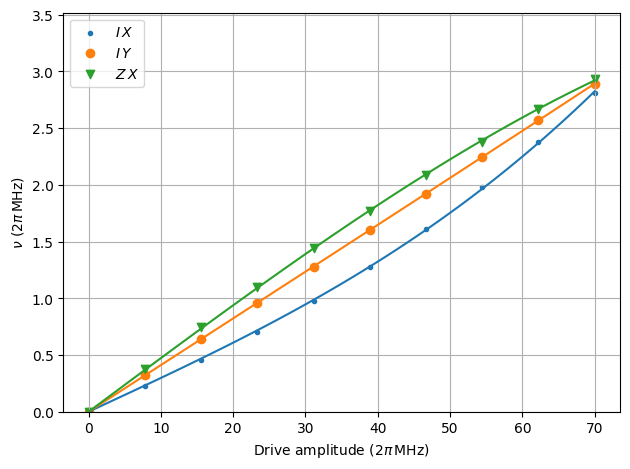

In [12]:
selection = [(0, 1), (0, 2), (3, 1)]
plot_amplitude_scan(physical_amplitudes, components_list_ct, select_components=selection,
                    amp_scale=FrequencyScale.MHz, compo_scale=FrequencyScale.MHz);

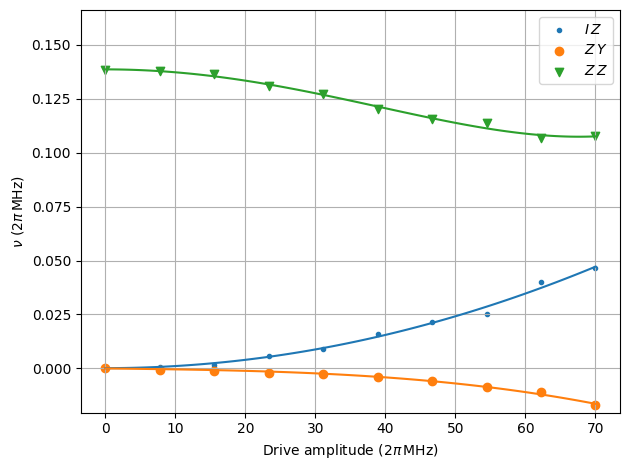

In [13]:
selection = [(0, 3), (3, 2), (3, 3)]
plot_amplitude_scan(physical_amplitudes, components_list_ct, select_components=selection,
                    amp_scale=FrequencyScale.MHz, compo_scale=FrequencyScale.MHz);